In [1]:
import os
import pickle
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.spatial import Delaunay
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import networkx as nx
from itertools import combinations
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# =====================================================
#                   Utility Functions
# =====================================================

def load_data(filepath: str) -> dict:
    """
    Load data from pickle file. The data is expected to be a dictionary:
    {node_identifier: pd.DataFrame with 'traffic_flow', 'Xkoordinat', 'Ykoordinat'}
    """
    with open(filepath, "rb") as f:
        data = pickle.load(f)
    return data


def split_dataframes(df_dict: dict, train_ratio=0.7, val_ratio=0.1):
    """
    Splits the dictionary of DataFrames into train, validation, and test sets.
    Splits are done by time sequence.

    Args:
        df_dict: {node_key: pd.DataFrame}
        train_ratio: fraction of data for training
        val_ratio: fraction of data for validation

    Returns:
        df_dict_train, df_dict_val, df_dict_test
    """
    df_dict_train, df_dict_val, df_dict_test = {}, {}, {}
    for key, df in df_dict.items():
        n = len(df)
        train_end = int(n * train_ratio)
        val_end = int(n * (train_ratio + val_ratio))
        df_train = df.iloc[:train_end].copy()
        df_val = df.iloc[train_end:val_end].copy()
        df_test = df.iloc[val_end:].copy()

        df_dict_train[key] = df_train
        df_dict_val[key] = df_val
        df_dict_test[key] = df_test

    return df_dict_train, df_dict_val, df_dict_test


def create_sliding_window_data(df_dict: dict, lookback: int, pred_horizon: int):
    """
    Create sliding windows for each node.
    Returns {node: X_node}, {node: y_node}
    X_node shape: (#samples, lookback), y_node shape: (#samples, pred_horizon)
    """
    X_dict, y_dict = {}, {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node, y_node = [], []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i+lookback])
            y_node.append(node_series[i+lookback:i+lookback+pred_horizon])
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


def combine_node_data(X_dict: dict, y_dict: dict):
    """
    Combine data from all nodes into single arrays.
    """
    X_list = [X_dict[node] for node in X_dict]
    y_list = [y_dict[node] for node in y_dict]
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

In [3]:
def clean_graph(graph: nx.Graph) -> nx.Graph:
    """
    Clean the graph: remove self-loops, duplicate edges, keep largest component.
    """
    g = graph.copy()
    g.remove_edges_from(list(nx.selfloop_edges(g)))

    if len(g.nodes) > 0:
        largest_component = max(nx.connected_components(g), key=len)
        g = g.subgraph(largest_component).copy()

    return g

# =====================================================
#                   Graph Construction
# =====================================================

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph where edges are based on spatial proximity.
    """
    graph = nx.Graph()
    coords = {}
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        coords[key] = (x, y)

    # Compute all pairwise distances
    keys = list(df_dict.keys())
    dist_list = []
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            x1, y1 = coords[k1]
            x2, y2 = coords[k2]
            dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            dist_list.append((k1, k2, dist))

    # Sort edges by distance (ascending)
    dist_list.sort(key=lambda x: x[2])

    # Add edges while respecting degree constraints
    for k1, k2, dist in dist_list:
        if graph.degree[k1] < degree and graph.degree[k2] < degree:
            if weighted:
                # Normalize weights if desired
                graph.add_edge(k1, k2, weight=1/(1+dist))
            else:
                graph.add_edge(k1, k2)


    graph = clean_graph(graph)
    return graph


def create_delaunay_graph(df_dict):
    """
    Create a graph based on the Delaunay triangulation of spatial coordinates.

    Parameters:
        df_dict (dict): A dictionary where keys are node identifiers and values are
                        pandas DataFrames containing 'Xkoordinat' and 'Ykoordinat'.

    Returns:
        nx.Graph: A Delaunay graph where edges are formed from Delaunay triangulation.
    """
    # Initialize an empty graph
    graph = nx.Graph()

    # Extract node coordinates and their identifiers
    nodes = []
    coords = []
    for key, df in df_dict.items():
        x, y = df['Xkoordinat'].iloc[0], df['Ykoordinat'].iloc[0]
        graph.add_node(key, x=x, y=y, traffic_flow=df['traffic_flow'].values)
        nodes.append(key)
        coords.append((x, y))

    # Perform Delaunay triangulation
    tri = Delaunay(coords)

    # Add edges from the Delaunay triangulation
    for simplex in tri.simplices:
        for i in range(3):
            for j in range(i + 1, 3):
                node1 = nodes[simplex[i]]
                node2 = nodes[simplex[j]]
                graph.add_edge(node1, node2)

    # Clean the graph (remove self-loops, keep largest connected component, etc.)
    graph = clean_graph(graph)

    return graph

def create_correlation_graph(df_dict_train, df_dict_full, threshold=0.5, weighted=False, degree=6):
    """
    Create a correlation-based graph using training data for correlation calculation.
    """
    graph = nx.Graph()
    keys = list(df_dict_full.keys())
    for key, df in df_dict_full.items():
        graph.add_node(key, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Compute correlation
    corr_matrix = {}
    for i, k1 in enumerate(keys):
        for j, k2 in enumerate(keys[i+1:], i+1):
            corr = np.corrcoef(df_dict_train[k1]['traffic_flow'], df_dict_train[k2]['traffic_flow'])[0, 1]
            corr_matrix[(k1, k2)] = corr
            corr_matrix[(k2, k1)] = corr

    # Sort edges by correlation
    for k1 in keys:
        potential = [(k2, corr_matrix[(k1, k2)]) for k2 in keys if k1 != k2 and (k1, k2) in corr_matrix]
        potential.sort(key=lambda x: -x[1])  # descending order by correlation
        for k2, c in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree and c > threshold:
                if weighted:
                    graph.add_edge(k1, k2, weight=c)
                else:
                    graph.add_edge(k1, k2)
    
    # find any nodes that are not connected to any other nodes, and connect
    graph = clean_graph(graph)
    return graph


def create_cosine_graph(df_dict, weighted=False, degree=4):
    """
    Create a graph based on cosine similarity between full node time series.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    features = [df_dict[k]['traffic_flow'].values for k in keys]
    features = np.array(features)  # shape: (#nodes, #timesteps)
    # Compute cosine similarity
    norm = np.linalg.norm(features, axis=1, keepdims=True)
    normed = features / (norm + 1e-8)
    sim_matrix = normed @ normed.T  # cosine similarity

    for i, k1 in enumerate(keys):
        graph.add_node(k1,
                       x=df_dict[k1]['Xkoordinat'].iloc[0],
                       y=df_dict[k1]['Ykoordinat'].iloc[0],
                       traffic_flow=df_dict[k1]['traffic_flow'].values)

    # Sort by similarity
    for i, k1 in enumerate(keys):
        potential = [(keys[j], sim_matrix[i, j]) for j in range(len(keys)) if i != j]
        potential.sort(key=lambda x: -x[1])
        for k2, sim_val in potential:
            if graph.degree[k1] < degree and graph.degree[k2] < degree:
                if weighted:
                    graph.add_edge(k1, k2, weight=sim_val)
                else:
                    graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_fully_connected_graph(df_dict, weighted=False):
    """
    Create a fully connected graph. Optionally assign random weights.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            if weighted:
                graph.add_edge(k1, k2, weight=np.random.rand())
            else:
                graph.add_edge(k1, k2)
    graph = clean_graph(graph)
    return graph


def create_dynamic_weight_graph(df_dict, lookback, pred_horizon, adaptive_factor=1.0, max_degree=4):
    """
    Create a graph with dynamic weights based on correlation of sliding windows.
    """
    graph = nx.Graph()
    keys = list(df_dict.keys())
    for k in keys:
        df = df_dict[k]
        graph.add_node(k, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0],
                       traffic_flow=df['traffic_flow'].values)

    # Precompute sliding windows
    sliding_windows = {
        k: np.lib.stride_tricks.sliding_window_view(df_dict[k]['traffic_flow'].values, lookback)[:-pred_horizon]
        for k in keys
    }

    # Compute avg correlation over time for each pair
    for i, k1 in enumerate(keys):
        for k2 in keys[i+1:]:
            w1 = sliding_windows[k1]
            w2 = sliding_windows[k2]
            # correlation per window
            corrs = []
            for t in range(min(len(w1), len(w2))):
                if np.std(w1[t]) > 0 and np.std(w2[t]) > 0:
                    c = np.corrcoef(w1[t], w2[t])[0, 1]
                    corrs.append(c)
            if len(corrs) > 0:
                avg_weight = np.mean(corrs)
                threshold = adaptive_factor * avg_weight
                if avg_weight > threshold:
                    graph.add_edge(k1, k2, weight=avg_weight)

    # Enforce max degree
    for node in list(graph.nodes()):
        edges = sorted(graph.edges(node, data=True), key=lambda x: x[2]['weight'], reverse=True)
        if len(edges) > max_degree:
            for edge in edges[max_degree:]:
                graph.remove_edge(edge[0], edge[1])

    graph = clean_graph(graph)
    return graph


def TOTAL_RANDOM_WEIGHTS(df_dict, degrees=32):
    # Initialize a graph
    num_nodes = len(df_dict)
    graph = nx.Graph()

    # Add nodes with attributes
    for i, (key, df) in enumerate(df_dict.items()):
        graph.add_node(i, x=df['Xkoordinat'].iloc[0], y=df['Ykoordinat'].iloc[0], traffic_flow=df['traffic_flow'].values)

    # Randomly add edges while respecting degree constraints
    nodes = list(graph.nodes)
    max_attempts = num_nodes * degrees * 10  # Safety limit to prevent infinite loops
    attempts = 0

    while any(graph.degree(n) < degrees for n in nodes):
        u, v = np.random.choice(nodes, size=2, replace=False)
        # Add an edge only if it doesn't exist and both nodes are under degree limit
        if not graph.has_edge(u, v) and graph.degree(u) < degrees and graph.degree(v) < degrees:
            graph.add_edge(u, v, weight=np.random.rand())
        
        attempts += 1
        if attempts >= max_attempts:
            print("Warning: Maximum attempts reached, stopping early.")
            break

    # Return the graph and edge weights
    return graph, nx.get_edge_attributes(graph, 'weight')

In [4]:
# =====================================================
#                   Model Definition
# =====================================================

class TrafficGCN(nn.Module):
    """
    A GCN-based model for predicting future traffic flow.
    """
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x


# =====================================================
#                   Metrics
# =====================================================

def mape_loss(y_true, y_pred):
    """
    Mean Absolute Percentage Error.
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def vape_loss(y_true, y_pred):
    """
    Variance Absolute Percentage Error = 
    (var(|y_true - y_pred|) / var(y_true)) * 100
    """
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    diff = np.abs(y_true - y_pred)
    var_diff = np.var(diff)
    var_true = np.var(y_true)
    if var_true == 0:
        return 0.0
    return (var_diff / var_true) * 100

def rmse_loss(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true.detach().cpu().numpy(), y_pred.detach().cpu().numpy()))


class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        epsilon = 1e-7  # Small value to avoid division by zero
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100

In [6]:
# =====================================================
#                   Training & Evaluation
# =====================================================
def train_model(model, train_data, val_data, epochs, lr, device="cuda:0"):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=50, cooldown=0, min_lr=1e-6)

    best_val_loss = float('inf')
    best_state = None
    early_stopping_patience = 200
    no_improve = 0

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(train_data)
        loss = criterion(out, train_data.y)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)

        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Step the scheduler based on validation loss
        scheduler.step(val_loss.item())

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_state = model.state_dict()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve > early_stopping_patience:
            # Early stopping triggered
            break
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Best Val Loss: {best_val_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses


def evaluate_model(model, test_data):
    """
    Evaluate the model on test data using MAPE, VAPE, and RMSE.
    """
    model.eval()
    with torch.no_grad():
        pred = model(test_data)

    mape = mape_loss(test_data.y, pred)
    vape = vape_loss(test_data.y, pred)
    rmse = rmse_loss(test_data.y, pred)
    return mape, vape, rmse, pred.cpu().numpy(), test_data.y.cpu().numpy()


In [7]:
# =====================================================
#                   Main Execution
# =====================================================

# Hyperparameters
DATA_PATH = "data_prep/one_year.pkl"  # Adjust your path
TRAIN_RATIO = 0.5
VAL_RATIO = 0.3
LOOKBACK = 50
PRED_HORIZON = 1
HIDDEN_CHANNELS = 32
LR = 1e-3
EPOCHS = 1
DEGREE = 6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and split data
final_dataframes = load_data(DATA_PATH)
df_dict_train, df_dict_val, df_dict_test = split_dataframes(final_dataframes, TRAIN_RATIO, VAL_RATIO)

# Create sliding window data
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, LOOKBACK, PRED_HORIZON)
X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, LOOKBACK, PRED_HORIZON)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, LOOKBACK, PRED_HORIZON)

node_lengths = {node: X_train_dict[node].shape[0] for node in X_train_dict}

# Combine data
X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float, device=device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

# Create a graph (choose any one you want to test)
# graph = create_distance_graph(final_dataframes, weighted=True, degree=DEGREE)
# graph = create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE)
# graph = create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE)
# graph = create_dynamic_weight_graph(df_dict_train, LOOKBACK, PRED_HORIZON, adaptive_factor=0.2, max_degree=DEGREE)
# graph = create_fully_connected_graph(final_dataframes, weighted=True)


# Now using the updated train_model in the main training loop

graph_models = {
    "Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=DEGREE),
    "Correlation_Weighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE),
    "Cosine_Weighted": lambda: create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE),
    "Fully_Connected_Weighted": lambda: create_fully_connected_graph(final_dataframes, weighted=True),
    "Random_Weighted": lambda: TOTAL_RANDOM_WEIGHTS(final_dataframes, degrees=DEGREE)[0],
    # Unweighted graphs
    "Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=DEGREE),
    "Delaunay_unweighted": lambda: create_delaunay_graph(final_dataframes),
    "Correlation_Unweighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=False, degree=DEGREE),
    "Cosine_Unweighted": lambda: create_cosine_graph(df_dict_train, weighted=False, degree=DEGREE),
    "Fully_Connected_Unweighted": lambda: create_fully_connected_graph(final_dataframes, weighted=False),
    "Random_Unweighted": lambda: nx.random_geometric_graph(len(final_dataframes), 0.1)
}

results = {}

for model_name, graph_fn in graph_models.items():
    graph = graph_fn()
    # Dump graph C:\Users\gonde\Desktop\P5\saved_graphs 
    with open(f"C:/Users/gonde/Desktop/P5/saved_graphs/{model_name}.pkl", "wb") as f:
        pickle.dump
    print(f"Training model with graph: {model_name}")

    node_mapping = {node: i for i, node in enumerate(graph.nodes())}
    edge_index = torch.tensor(
        [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
        dtype=torch.long, device=device
    ).t().contiguous()
    
    train_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor.view(-1, PRED_HORIZON))
    val_data = Data(x=X_val_tensor, edge_index=edge_index, y=y_val_tensor.view(-1, PRED_HORIZON))
    test_data = Data(x=X_test_tensor, edge_index=edge_index, y=y_test_tensor.view(-1, PRED_HORIZON))

    model = TrafficGCN(in_channels=LOOKBACK, hidden_channels=HIDDEN_CHANNELS, out_channels=PRED_HORIZON).to(device)
    train_losses, val_losses = train_model(model, train_data, val_data, EPOCHS, LR, device=device)

    mape, vape, rmse, preds, actuals = evaluate_model(model, test_data)

    # Store last 100 predictions and actual values
    last_10000_preds = preds[-10:]
    last_10000_actuals = actuals[-10:]

    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_mape": mape,
        "test_vape": vape,
        "test_rmse": rmse,
        "test_mse": rmse**2,
        "last_10000_predictions": last_10000_preds,
        "last_10000_actuals": last_10000_actuals,
        "Epoch Count": len(train_losses)
    }

# Print summary
print("======================== SUMMARY ========================")
for model_name, res in results.items():
    print(f"Model: {model_name}, Test RMSE: {res['test_rmse']:.4f}, Test MSE {res['test_mse']:.4}, Test MAPE: {res['test_mape']:.4f}%, Test VAPE: {res['test_vape']:.4f}%")



Training model with graph: Distance_Weighted
Epoch 0, Train Loss: 30002.3125, Val Loss: 30464.4727, Best Val Loss: 30464.4727, Learning Rate: 0.001000
Training model with graph: Correlation_Weighted
Epoch 0, Train Loss: 36771.1797, Val Loss: 37200.4844, Best Val Loss: 37200.4844, Learning Rate: 0.001000
Training model with graph: Cosine_Weighted
Epoch 0, Train Loss: 21597.7832, Val Loss: 21522.5996, Best Val Loss: 21522.5996, Learning Rate: 0.001000
Training model with graph: Fully_Connected_Weighted
Epoch 0, Train Loss: 33340.4219, Val Loss: 35010.9414, Best Val Loss: 35010.9414, Learning Rate: 0.001000
Training model with graph: Random_Weighted
Epoch 0, Train Loss: 37754.3711, Val Loss: 37990.5781, Best Val Loss: 37990.5781, Learning Rate: 0.001000
Training model with graph: Distance_Unweighted
Epoch 0, Train Loss: 74516.6719, Val Loss: 74941.2422, Best Val Loss: 74941.2422, Learning Rate: 0.001000
Training model with graph: Delaunay_unweighted
Epoch 0, Train Loss: 25606.3691, Val Lo

In [ ]:
# Optionally save results to a file
with open("model_results_one_year.pkl", "wb") as f:
    pickle.dump(results, f)

In [ ]:
# print("Last 10 predictions vs Actuals:")
# for p, a in zip(last_100_preds, last_100_actuals):
#     print(f"Pred: {p[0]:.2f}  Actual: {a[0]:.2f}")

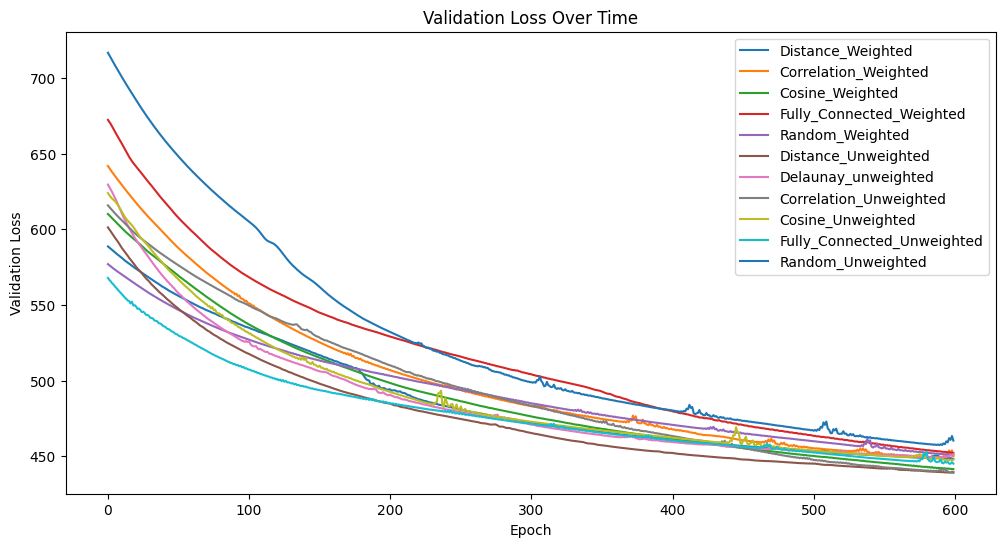

In [ ]:
# Plot the validation loss over time for all models in the same plot
plt.figure(figsize=(12, 6))
for model_name, res in results.items():
    plt.plot(res['val_losses'][200:800], label=model_name)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")

plt.title("Validation Loss Over Time")
plt.legend()
plt.show()

C:\Users\gonde\AppData\Local\Temp\ipykernel_17568\2067227144.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(model_names, rotation=45, ha='right')
C:\Users\gonde\AppData\Local\Temp\ipykernel_17568\2067227144.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(model_names, rotation=45, ha='right')


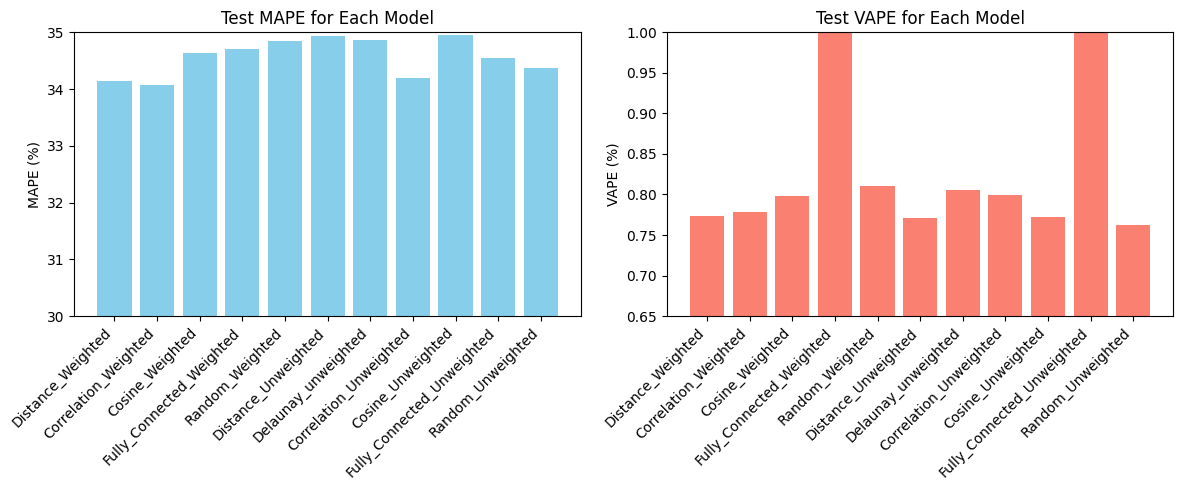

Summary Table:
                     Model  MAPE (%)  VAPE (%)      RMSE       R2  Epoch Count
         Distance_Weighted 34.141380  0.773315 16.624765 0.940265         5000
      Correlation_Weighted 34.067628  0.778055 16.642323 0.940865         5000
           Cosine_Weighted 34.640944  0.797701 16.824523 0.941896         5000
  Fully_Connected_Weighted 34.702751  1.031562 18.602056 0.942341         4485
           Random_Weighted 34.843659  0.810796 16.906942 0.939756         5000
       Distance_Unweighted 34.933364  0.771379 16.612134 0.940051         5000
       Delaunay_unweighted 34.861341  0.806133 16.951826 0.933863         2261
    Correlation_Unweighted 34.192178  0.799622 16.849997 0.937985         5000
         Cosine_Unweighted 34.945640  0.771806 16.590983 0.939846         5000
Fully_Connected_Unweighted 34.545237  1.062885 18.832156 0.939274         5000
         Random_Unweighted 34.368929  0.762161 16.519591 0.940202         5000


In [ ]:
from sklearn.metrics import r2_score

# 1. Plot MAPE and VAPE values for each model
model_names = list(results.keys())
mapes = [results[m]['test_mape'] for m in model_names]
vapes = [results[m]['test_vape'] for m in model_names]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(model_names, mapes, color='skyblue')
ax[0].set_title('Test MAPE for Each Model')
ax[0].set_ylim(30, 35)
ax[0].set_xticklabels(model_names, rotation=45, ha='right')
ax[0].set_ylabel('MAPE (%)')

ax[1].bar(model_names, vapes, color='salmon')
ax[1].set_title('Test VAPE for Each Model')
ax[1].set_xticklabels(model_names, rotation=45, ha='right')
ax[1].set_ylabel('VAPE (%)')
ax[1].set_ylim(0.65, 1.0)

plt.tight_layout()
plt.show()

# R2
# 3. Plot Actual vs. Predicted for a selected model and compute R²
selected_model = "Distance_Weighted"  # change to any model you want
preds = results[selected_model]["last_10000_predictions"].flatten()
actuals = results[selected_model]["last_10000_actuals"].flatten()

# Compute R²
r2 = r2_score(actuals, preds)

# 2. Create a table summarizing MAPE, VAPE, RMSE, and Epoch Count
data_for_table = {
    "Model": model_names,
    "MAPE (%)": mapes,
    "VAPE (%)": vapes,
    "RMSE": [results[m]['test_rmse'] for m in model_names],
    "R2": [r2_score(results[m]['last_10000_actuals'], results[m]['last_10000_predictions']) for m in model_names],
    "Epoch Count": [results[m]['Epoch Count'] for m in model_names]

}
df = pd.DataFrame(data_for_table)
print("Summary Table:")
print(df.to_string(index=False))




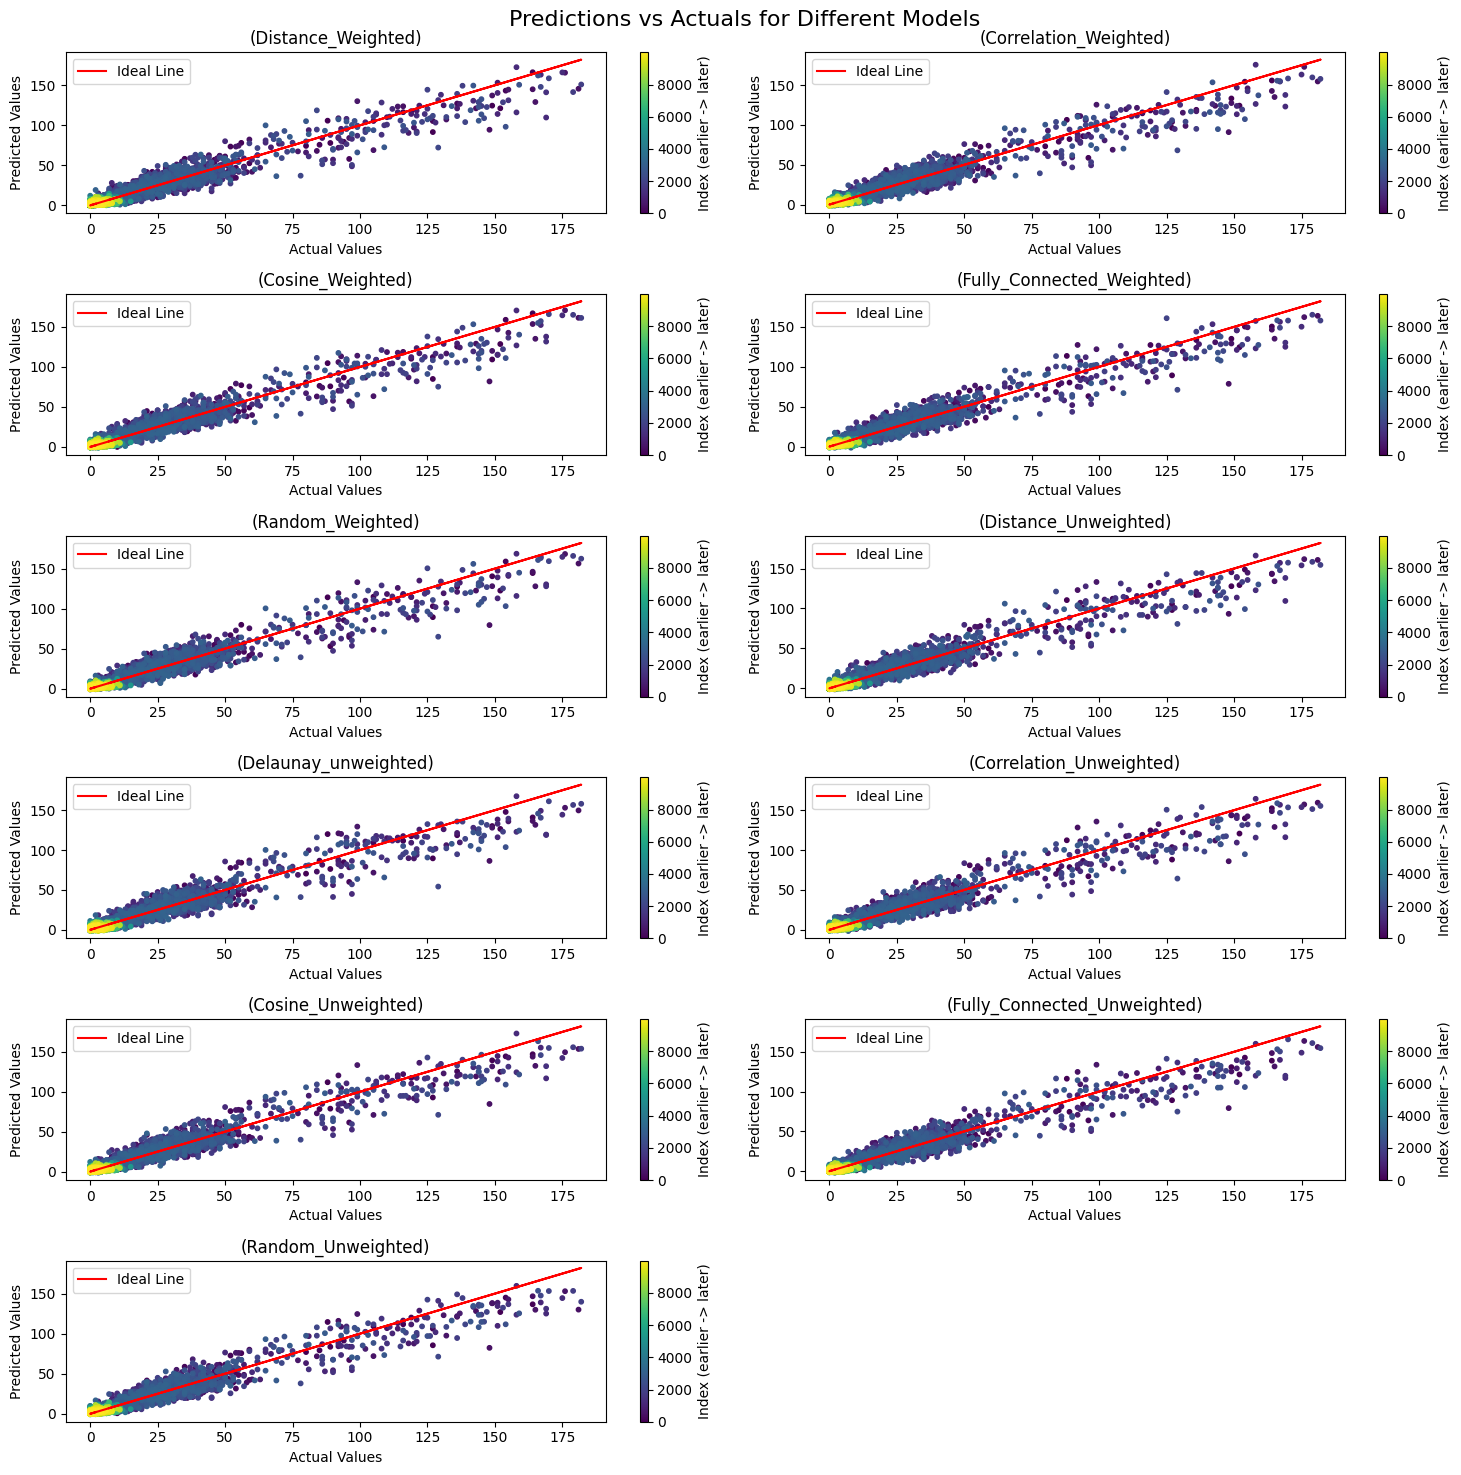

In [ ]:
# loop over all models and Plott the evolution of predictions vs actual over time, in subplots
plt.figure(figsize=(15, 15))
for i, model_name in enumerate(results.keys()):
    actuals = results[model_name]["last_10000_actuals"]
    preds = results[model_name]["last_10000_predictions"]
    # set a main title over all subplots
    plt.suptitle("Predictions vs Actuals for Different Models", fontsize=16)

    plt.subplot(6, 2, i+1)
    plt.scatter(actuals, preds, c=np.arange(len(preds)), cmap='viridis', s=10)
    plt.plot(actuals, actuals, color='red', label='Ideal Line')
    plt.colorbar(label='Index (earlier -> later)')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'({model_name})')
    plt.legend()
plt.tight_layout()
plt.show()

### Analyze prediction horizon and Lookback

In [ ]:
import itertools
import pandas as pd
from sklearn.metrics import r2_score

# Define ranges for lookback periods and prediction horizons
lookback_periods = [5, 10, 20, 50]  # adjust as needed
prediction_horizons = [1, 2,  4, 20, 60]  # adjust as needed

graph_models = {
    #"Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True, degree=DEGREE),
    "Correlation_Weighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=True, degree=DEGREE),
    #"Cosine_Weighted": lambda: create_cosine_graph(df_dict_train, weighted=True, degree=DEGREE),
    #"Fully_Connected_Weighted": lambda: create_fully_connected_graph(final_dataframes, weighted=True),
    #"Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False, degree=DEGREE),
    "Correlation_Unweighted": lambda: create_correlation_graph(df_dict_train, final_dataframes, threshold=0.5, weighted=False, degree=DEGREE),
    #"Cosine_Unweighted": lambda: create_cosine_graph(df_dict_train, weighted=False, degree=DEGREE),
    #"Fully_Connected_Unweighted": lambda: create_fully_connected_graph(final_dataframes, weighted=False),
}

results = []

# Iterate through combinations of lookback periods and prediction horizons
for lookback, pred_horizon in itertools.product(lookback_periods, prediction_horizons):
    print(f"=== Testing Lookback: {lookback}, Prediction Horizon: {pred_horizon} ===")

    # Create sliding window data for train, val, and test sets
    X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
    X_val_dict, y_val_dict = create_sliding_window_data(df_dict_val, lookback, pred_horizon)
    X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

    # Combine data
    X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
    X_val, y_val = combine_node_data(X_val_dict, y_val_dict)
    X_test, y_test = combine_node_data(X_test_dict, y_test_dict)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float, device=device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float, device=device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float, device=device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float, device=device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float, device=device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float, device=device)

    # Train and evaluate each graph model
    for model_name, graph_fn in graph_models.items():
        graph = graph_fn()

        # If graph has no edges or nodes, skip
        if graph.number_of_nodes() == 0:
            print(f"{model_name}: Graph is empty, skipping.")
            continue

        node_mapping = {node: i for i, node in enumerate(graph.nodes())}
        edge_index = torch.tensor(
            [[node_mapping[u], node_mapping[v]] for u, v in graph.edges()],
            dtype=torch.long, device=device
        ).t().contiguous()

        train_data = Data(x=X_train_tensor, edge_index=edge_index, y=y_train_tensor.view(-1, pred_horizon))
        val_data = Data(x=X_val_tensor, edge_index=edge_index, y=y_val_tensor.view(-1, pred_horizon))
        test_data = Data(x=X_test_tensor, edge_index=edge_index, y=y_test_tensor.view(-1, pred_horizon))

        # Initialize model
        hc = HIDDEN_CHANNELS  # or a fixed number like 32
        model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon).to(device)

        # Train model
        train_losses, val_losses = train_model(model, train_data, val_data, EPOCHS, LR, device=device)

        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            test_out = model(test_data)
            criterion = torch.nn.MSELoss()
            test_loss = criterion(test_out, test_data.y)
            test_rmse = torch.sqrt(test_loss).item()
            test_mae = torch.mean(torch.abs(test_out - test_data.y)).item()

            # Compute additional metrics
            mape = mape_loss(test_data.y, test_out)
            vape = vape_loss(test_data.y, test_out)
            r2 = r2_score(test_data.y.cpu().numpy(), test_out.cpu().numpy())

        # Print minimal info for this combination
        print(f"Model: {model_name}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, MAPE: {mape:.4f}%, VAPE: {vape:.4f}%, R²: {r2:.4f}")

        # Store results
        results.append({
            "Lookback": lookback,
            "Prediction_Horizon": pred_horizon,
            "Model": model_name,
            "Test RMSE": test_rmse,
            "Test MAE": test_mae,
            "MAPE (%)": mape,
            "VAPE (%)": vape,
            "R2": r2,
            "Epoch Count": len(train_losses)
        })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results)
print("===== Summary of All Results =====")
print(results_df.to_string(index=False))


=== Testing Lookback: 5, Prediction Horizon: 30 ===


NameError: name 'create_sliding_window_data' is not defined